<a href="https://colab.research.google.com/github/imrib/ImriBregman-HW/blob/main/Cat%26Dog_VGGNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Act like a Python programmer in the Google Collab environment.
Use the VGGNET network to classify dog ​​and cat data.
Use Karas.
I will ask to freeze the first layers of the network. Leave only the last convolution layer including the softmax.
Don't write anything right now. Is it understood?

The folder you will work on is: /content/drive/MyDrive/cats_and_dogs_filtered

Do network training according to the data. Finally, save the weights.
Show the weights.
Show Confusion Matrix.
Save the Confusion Matrix.

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/10
63/63 [==============================] - 17s 208ms/step - loss: 1.4495 - accuracy: 0.8380 - val_loss: 0.1824 - val_accuracy: 0.9350
Epoch 2/10
63/63 [==============================] - 13s 201ms/step - loss: 0.1202 - accuracy: 0.9585 - val_loss: 0.1559 - val_accuracy: 0.9570
Epoch 3/10
63/63 [==============================] - 13s 202ms/step - loss: 0.0434 - accuracy: 0.9870 - val_loss: 0.1469 - val_accuracy: 0.9720
Epoch 4/10
63/63 [==============================] - 14s 223ms/step - loss: 0.0258 - accuracy: 0.9945 - val_loss: 0.2402 - val_accuracy: 0.9450
Epoch 5/10
63/63 [==============================] - 15s 224ms/step - loss: 0.0293 - accuracy: 0.9925 - val_loss: 0.2183 - val_accuracy: 0.9450
Epoch 6/10
63/63 [==============================] - 13s 206ms/step - loss: 0.0382 - accuracy: 0.9900 - val_loss: 0.2767 - val_accuracy: 0.9540
Epoch 7/10
63/63 [==============================] - 13s 207m

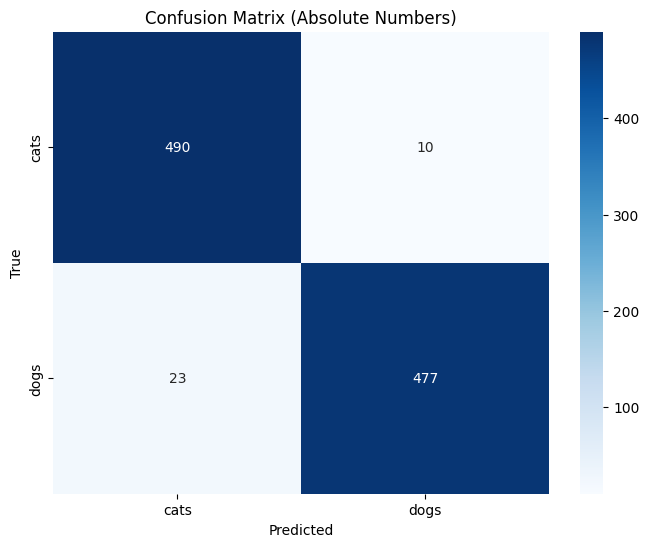

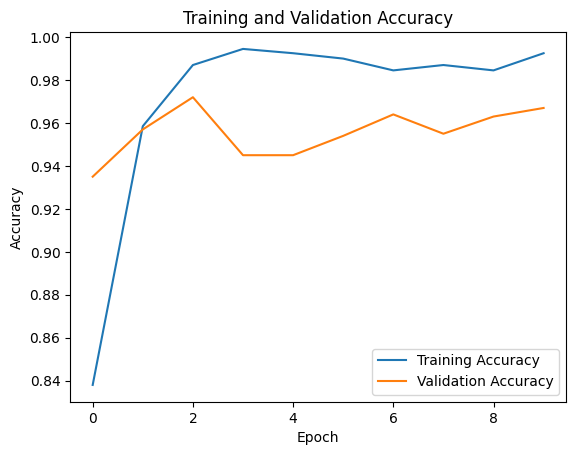

In [36]:
# Change directory to the dataset folder
data_folder = '/content/drive/MyDrive/cats_and_dogs_filtered'

# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set up data generators using tf.keras.preprocessing.image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    os.path.join(data_folder, 'train'),
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    os.path.join(data_folder, 'validation'),
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False  # No need to shuffle validation dataset
)

# Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model using VGG16 and add custom layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification for cat and dog

# Freeze the first layers except the last convolution layer
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Save the weights
model.save_weights(os.path.join(data_folder, 'vggnet_weights.h5'))

# Display the weights
model.summary()

# Evaluate the model on the validation set
eval_result = model.evaluate(validation_dataset)
print("Validation Loss:", eval_result[0])
print("Validation Accuracy:", eval_result[1])

# Predict on the test data
Y_pred = model.predict(validation_dataset)
y_pred = tf.argmax(Y_pred, axis=1)

# Extract true labels from validation dataset and convert to class indices
y_true = tf.argmax(tf.concat([y for x, y in validation_dataset], axis=0), axis=1)

# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)

# Display confusion matrix with absolute numbers
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_dataset.class_names,
            yticklabels=validation_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Numbers)')
plt.show()


# Save confusion matrix
np.savetxt(os.path.join(data_folder, 'confusion_matrix.txt'), conf_matrix, fmt='%d')

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **weights from Keras to PyTorch**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


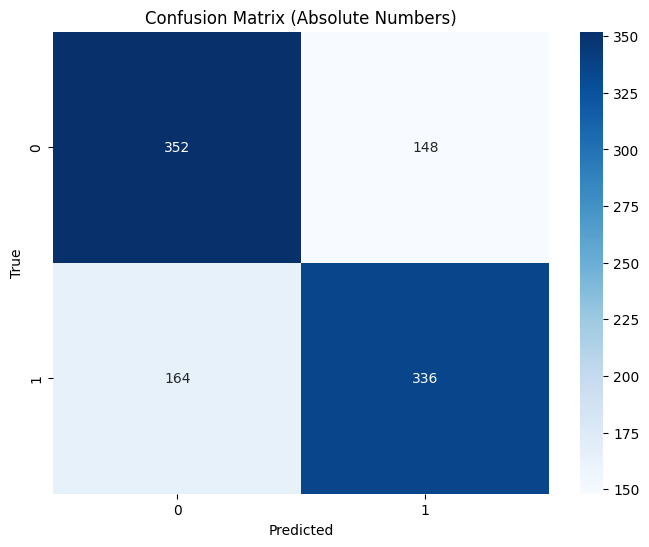

In [40]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

# Assuming 'cats_and_dogs_filtered' contains 'train' and 'validation' folders
data_dir = '/content/drive/MyDrive/cats_and_dogs_filtered'
train_dir = data_dir + '/train'
val_dir = data_dir + '/validation'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load data using torchvision ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the saved Keras weights
keras_weights_file = '/content/drive/MyDrive/cats_and_dogs_filtered/vggnet_weights.h5'
keras_weights = h5py.File(keras_weights_file, 'r')

# Create an instance of the PyTorch model
pytorch_model = models.vgg16(pretrained=False)

# Load Keras weights into PyTorch model
with torch.no_grad():
    for i, (name, param) in enumerate(pytorch_model.named_parameters()):
        weight_key = f'{i}/kernel:0'
        bias_key = f'{i}/bias:0'

        if weight_key in keras_weights:
            weight = torch.from_numpy(keras_weights[weight_key][...].transpose((3, 2, 0, 1)))
            param.data.copy_(weight)

        if bias_key in keras_weights:
            bias = torch.from_numpy(keras_weights[bias_key][...])
            param.data.copy_(bias)

# Set requires_grad to True for all parameters
for param in pytorch_model.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model.to(device)

for epoch in range(num_epochs):
    pytorch_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
pytorch_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pytorch_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix with absolute numbers
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Numbers)')
plt.show()
